## Preface



In [1]:
!pip install CFEDemands
import cfe

In [2]:
import pandas as pd

If need be&#x2026;



## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:


| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|j,u|t,m|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



Note that in some cases not the food items for the FCT (e.g., for Niger) are **not** yet all matched up (&ldquo;harmonized&rdquo;) with food labels indexed by `j` in the expenditure,
consumption and price datasets.



In [3]:
# from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

# Get expenditures...
x = pd.read_csv("data/tanzania/Tanzania [Reformatted] - Food Expenditures (2019-20).csv")

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = pd.read_csv("data/tanzania/Tanzania [Reformatted] - Household Characteristics (2019-20).csv")

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = pd.read_csv("new.csv")

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = pd.read_csv("data/tanzania/Tanzania [Reformatted] - FCT.csv")

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = pd.read_csv("data/uganda/Uganda - RDI.csv")
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `Regression` result.



In [4]:
import cfe

result = cfe.Regression(y=np.log(x.stack()),d=z)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Citrus Fruits               1.130966
Ripe Bananas                0.977499
Leafy Greens                0.671702
Plantains                   0.573747
Irish Potatoes              0.569504
Sweet Potatoes              0.560885
Vegetables (fresh)          0.515630
Soft drinks                 0.477239
Buns, Cakes And Biscuits    0.444066
Coconuts                    0.423381
Fish (fresh)                0.417848
Milk (fresh)                0.412032
Cassava Fresh               0.395648
Sugar                       0.394992
Cooking Oil                 0.391770
Macaroni, Spaghetti         0.390850
Wheat Flour                 0.390105
Pulses                      0.378353
Beef                        0.377320
Tea (dry)                   0.374065
Rice (husked)               0.310996
Bread                       0.300077
Chicken                     0.245496
Salt                        0.205973
Fish (dried)                0.188521
Maize (flour)               0.184789
Name: beta, dtype: float64

Make this persistent&#x2026;



In [5]:
result.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [6]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [7]:
fct.head()

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Cassava Fresh,1600,14.00,20.0,270,160,381.00,3.00,8.540,0.48,0.870,10,0.0,0.880,206.0,3.00
Chicken,2390,273.00,0.0,50,150,0.00,13.00,84.870,1.68,0.630,480,3.0,4.000,0.0,19.00
Cooking Oil,8840,0.00,0.0,0,0,0.00,0.00,0.000,0.00,0.000,0,0.0,0.000,0.0,0.00
Leafy Greens,22,1.09,0.0,0,40,4.07,0.32,0.375,0.00,0.082,0,0.0,0.071,15.2,0.31
Millet & Sorghum (flour),3740,109.00,90.0,840,80,721.00,30.00,46.680,2.87,4.160,0,0.0,3.800,0.0,17.00


In [8]:
qhat

j                                       Beef     Bread  \
t       m             i                                  
2019-20 Dar Es Salaam 0001-001-004  1.078619  1.235415   
                      0034-001-001  2.424245  4.169937   
                      0042-001-001  0.829415  0.689657   
                      0051-001-002  0.990157  1.229447   
                      0051-001-003  1.889829  1.662207   
...                                      ...       ...   
                      0686-001-001  1.987418  1.047054   
                      0701-003-001  1.394720  1.678683   
                      0809-001-008  1.598154  1.555442   
                      0858-001-001  0.804523  0.810593   
                      0858-001-002  1.576298  4.276094   

j                                   Buns, Cakes And Biscuits  Cassava Fresh  \
t       m             i                                                       
2019-20 Dar Es Salaam 0001-001-004                  0.744709       1.849774   
                      0034-001-001                  1.836807       3.996607   
                      0042-001-001                  0.620870       1.607644   
                      0051-001-002                  0.722038       1.669950   
                      0051-001-003                  1.643646       4.358663   
...                                                      ...            ...   
                      0686-001-001                  1.322475       2.824425   
                      0701-003-001                  0.926790       2.262184   
                      0809-001-008                  1.361291       3.189101   
                      0858-001-001                  0.571811       1.033878   
                      0858-001-002                  3.701019       7.993756   

j                                    Chicken  Citrus Fruits  Coconuts  \
t       m             i                                                 
2019-20 Dar Es Salaam 0001-001-004  0.566691       1.032673  1.190305   
                      0034-001-001  1.345766       0.891811  2.595711   
                      0042-001-001  0.659921       0.277180  0.876468   
                      0051-001-002  0.536094       0.471805  0.985901   
                      0051-001-003  1.148077       4.189388  2.548655   
...                                      ...            ...       ...   
                      0686-001-001  1.033814       1.247883  1.481351   
                      0701-003-001  0.946417       0.942468  1.238012   
                      0809-001-008  0.936571       2.947933  1.994962   
                      0858-001-001  0.563346       0.137728  0.631329   
                      0858-001-002  1.354604       4.070616  2.925601   

j                                   Cooking Oil  Fish (dried)  Fish (fresh)  \
t       m             i                                                       
2019-20 Dar Es Salaam 0001-001-004     0.446898      0.323940      0.487121   
                      0034-001-001     0.676687      0.637681      1.645637   
                      0042-001-001     0.354145      0.298233      0.414454   
                      0051-001-002     0.437622      0.355409      0.579383   
                      0051-001-003     1.088953      0.573864      1.439548   
...                                         ...           ...           ...   
                      0686-001-001     0.744136      0.349938      0.833462   
                      0701-003-001     0.615375      0.390575      0.874103   
                      0809-001-008     0.780240      0.465433      1.004370   
                      0858-001-001     0.340735      0.293283      0.429378   
                      0858-001-002     1.566515      0.838931      4.265668   

j                                   ...    Pulses  Rice (husked)  \
t       m             i             ...                            
2019-20 Dar Es Salaam 0001-001-004  ...  0.872171       1.629317   
                      0034-001-001 

In [9]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          71557.358091
Protein          1854.407964
Fiber             513.466926
Folate           6289.164438
Calcium          9109.644401
Carbohydrate    12555.840907
Iron              271.771219
Niacin            434.817690
Riboflavin         26.872703
Thiamin            31.159481
Vitamin A        7350.857167
Vitamin B-12       78.212125
Vitamin B-6        51.720856
Vitamin C        1326.151016
Zinc              216.678637
dtype: float64

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [10]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

Now, what proportion of `hh_rwi` do households consume?



In [11]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

n                                     Energy   Protein     Fiber    Folate  \
t       m             i                                                      
2019-20 Dar Es Salaam 0001-001-004  2.552530  2.902643  1.434663  1.546364   
                      0034-001-001  1.184993  1.299374  0.636021  0.620317   
                      0042-001-001  1.104204  1.362988  0.557508  0.529565   
                      0051-001-002  1.360813  1.465849  0.665924  0.735789   
                      0051-001-003  1.929961  2.227054  1.097113  0.947834   
...                                      ...       ...       ...       ...   
                      0686-001-001  2.086514  2.499240  1.038065  0.902201   
                      0701-003-001  1.628523  1.972202  0.809282  0.781307   
                      0809-001-008  2.378187  2.654472  1.359475  1.242819   
                      0858-001-001  0.893162  0.937225  0.385091  0.359444   
                      0858-001-002  1.581495  1.675595  0.749444  0.764996   

n                                    Calcium  Carbohydrate      Iron  \
t       m             i                                                
2019-20 Dar Es Salaam 0001-001-004  0.920107      7.884524  3.290193   
                      0034-001-001  0.282014      3.105873  0.976062   
                      0042-001-001  0.260044      2.658900  0.664128   
                      0051-001-002  0.424101      4.086091  1.569122   
                      0051-001-003  0.526130      4.722113  1.040701   
...                                      ...           ...       ...   
                      0686-001-001  0.448014      4.219678  1.115922   
                      0701-003-001  0.358233      3.385149  0.905769   
                      0809-001-008  0.745503      6.821273  1.611130   
                      0858-001-001  0.185485      2.258096  0.474672   
                      0858-001-002  0.316492      4.389482  1.096450   

n                                     Niacin  Riboflavin   Thiamin  Vitamin A  \
t       m             i                                                         
2019-20 Dar Es Salaam 0001-001-004  2.537535    1.978182  2.505049   0.773387   
                      0034-001-001  1.010614    0.840581  1.044155   0.360379   
                      0042-001-001  0.994753    0.729059  0.889846   0.266543   
                      0051-001-002  1.227464    0.942892  1.198431   0.291952   
                      0051-001-003  1.707394    1.415201  1.586332   0.670759   
...                                      ...         ...       ...        ...   
                      0686-001-001  1.696829    1.320873  1.519133   0.565476   
                      0701-003-001  1.413226    1.105201  1.313691   0.437491   
                      0809-001-008  2.219006    1.782360  2.093420   0.778123   
                      0858-001-001  0.729493    0.547716  0.657532   0.152355   
                      0858-001-002  1.290073    1.014299  1.284578   0.409987   

n                                   Vitamin B-12  Vitamin B-6  Vitamin C  \
t       m             i                                                    
2019-20 Dar Es Salaam 0001-001-004      3.218614     3.742231   1.762289   
                      0034-001-001      1.069863     1.361830   0.516678   
                      0042-001-001      1.120951     1.314766   0.573318   
                      0051-001-002      1.593039     1.664637   0.647833   
                      0051-001-003      2.020219     2.673769   1.465236   
...                                          ...          ...        ...   
                      0686-001-001      2.141827     2.497883   1.171721   
                      0701-003-001      1.629714     1.937080   0.830561   
                      0809-001-008      2.633638     3.359232   1.770262   
                      0858-001-001      0.846758     0.873132   0.297039   
                      0858-001-002      1.288922     1.873954   0.934363   

n    

Graph ratios of adequacy for particular nutrients



<Axes: >

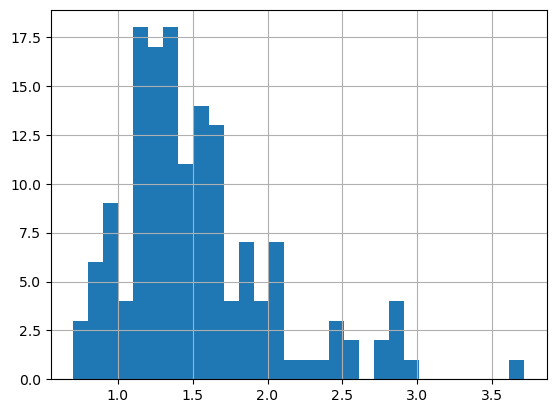

In [12]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)